In [1]:
import jax
import gpjax

/home/hardik/Desktop/Research/wind_disturbance_experiment/venv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.key(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

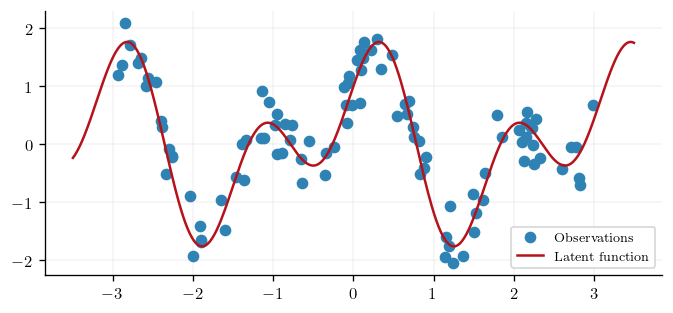

In [4]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

In [5]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

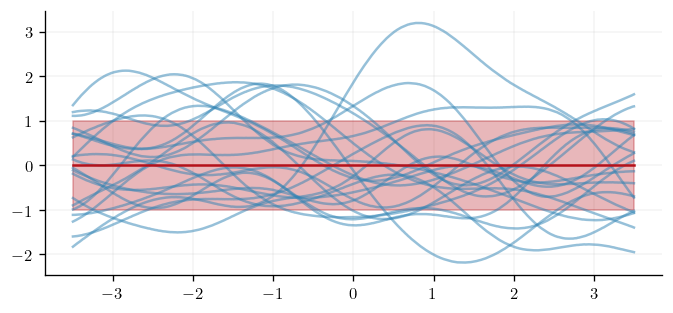

In [6]:

prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
# ax.legend(loc="best")

In [7]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

Array(124.80517341, dtype=float64)

In [8]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
)

Optimization terminated successfully.
         Current function value: 55.103686
         Iterations: 16
         Function evaluations: 19
         Gradient evaluations: 19


In [9]:
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=500,
    safe=True,
    key=key,
)

Running: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 193.45it/s, Value=55.10]


In [10]:
posterior

ConjugatePosterior(prior=Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1., dtype=float32, weak_type=True), variance=Array(1., dtype=float32, weak_type=True)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06), likelihood=Gaussian(num_datapoints=100, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(1., dtype=float32, weak_type=True)), jitter=1e-06)

In [11]:
opt_posterior

ConjugatePosterior(prior=Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(0.4562443, dtype=float32), variance=Array(1.2698635, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06), likelihood=Gaussian(num_datapoints=100, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.3199676, dtype=float32)), jitter=1e-06)

In [12]:

@jit
def predict(params, posterior):
    latent_dist = posterior.predict(xtest, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()
    return predictive_mean+jnp.sum(params), predictive_std
params = jnp.array([1,2,3])
predictive_mean, predictive_std = predict(params, opt_posterior)
predict_grad = jax.grad(predict, argnums=(0))
predict_grad(opt_posterior)

TypeError: jnp.linalg.inv requires ndarray or scalar arguments, got <class 'cola.ops.operators.Sum[cola.ops.operators.Dense, cola.ops.operators.Product[cola.ops.operators.ScalarMul, cola.ops.operators.Identity], cola.ops.operators.Product[cola.ops.operators.ScalarMul, cola.ops.operators.Identity]]'> at position 0.

In [13]:
# latent_dist = opt_posterior.predict(xtest, train_data=D)
# predictive_dist = opt_posterior.likelihood(latent_dist)

# predictive_mean = predictive_dist.mean()
# predictive_std = predictive_dist.stddev()

In [ ]:
opt_posterior

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))